In [1]:
%matplotlib inline
from fastai.vision import *
from fastai.callbacks import *
from torchvision.utils import make_grid

In [2]:
mnist_data = (ImageList.from_folder(untar_data(URLs.MNIST), convert_mode='L')
                       .split_by_folder('training', 'testing')
                       .label_from_folder()
                       .databunch())

# Utils

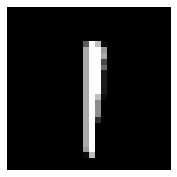

In [78]:
digit = mnist_data.train_ds.x[23181]
digit.show(cmap='gray')

In [169]:
n_degs = 19
degs = torch.linspace(0, 180, n_degs)
rot_digits = torch.stack([digit.clone().rotate(r).data for r in degs]).cuda()
rot_digits.shape

torch.Size([19, 1, 28, 28])

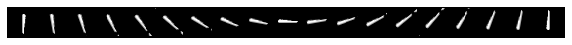

In [171]:
degs_img = make_grid(rot_digits, n_degs)
show_image(degs_img, figsize=(10,4));

# Softmax

In [11]:
class LeNet(nn.Sequential):
    def __init__(self):
        layers = [conv_layer(1, 20, norm_type=None), nn.MaxPool2d(2),
                  conv_layer(20, 50, norm_type=None), nn.MaxPool2d(2),
                  Flatten(), nn.Linear(2450, 500), nn.ReLU(True), nn.Dropout(0.5), nn.Linear(500,10), ]
        super().__init__(*layers)
        
softmax_model = LeNet().cuda()

In [12]:
xb,yb = mnist_data.one_batch(cpu=False, denorm=False)

In [13]:
with torch.no_grad(), Hooks(softmax_model.children(), lambda m,i,o: print(o.shape)) as hooks:
    print(xb.shape)
    yb_ = softmax_model.eval()(xb)

torch.Size([64, 1, 28, 28])
torch.Size([64, 20, 28, 28])
torch.Size([64, 20, 14, 14])
torch.Size([64, 50, 14, 14])
torch.Size([64, 50, 7, 7])
torch.Size([64, 2450])
torch.Size([64, 500])
torch.Size([64, 500])
torch.Size([64, 500])
torch.Size([64, 10])


In [14]:
softmax_learner = Learner(mnist_data, softmax_model, metrics=accuracy)

In [15]:
softmax_learner.fit(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.077099,0.047513,0.984100,03:14
1,0.055194,0.030035,0.989800,00:12
2,0.035801,0.028275,0.990200,00:13
3,0.032054,0.023355,0.991700,00:12
4,0.021338,0.027364,0.991400,00:12


In [230]:
with torch.no_grad(): yb_ = softmax_model.eval()(rot_digits)

In [231]:
pred = F.softmax(yb_, dim=1)
scores = (pred > 0.7).sum(0)
lbls = torch.arange(10)[scores>0]
lp = yb_[:,lbls]
lbls

tensor([1, 5, 7])

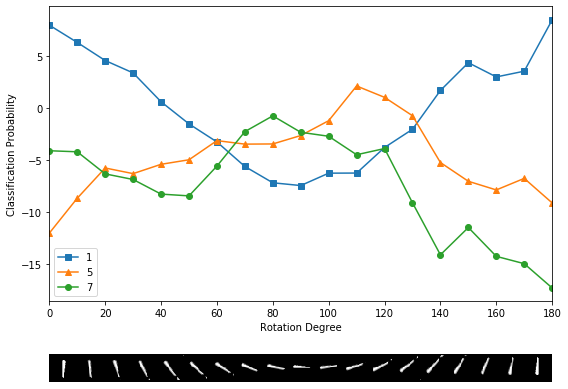

In [232]:
fig,axs = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={'height_ratios': [3, 1]})

for i,m in zip(range_of(lbls),['s','^','o']*10): axs[0].plot(degs, lp[:,i], marker=m)
axs[0].legend(lbls.tolist())
axs[0].set_xlim([0,180])  
axs[0].set_xlabel('Rotation Degree')
axs[0].set_ylabel('Classification Probability')

show_image(degs_img, ax=axs[1])
plt.tight_layout()

# ---